In [ ]:
!python -m spacy download es

In [ ]:
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
import string

from collections import Counter
from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

nltk.download('perluniprops')
nltk.download('nonbreaking_prefixes')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [ ]:
df_train = pd.read_pickle(data_path + "df_train.pickle")
df_test = pd.read_pickle(data_path + "df_test.pickle")
df_final = pd.read_pickle(data_path + "df_final.pickle")

df_test['final_label'] = df_test['final_label'].map({"racist":1, "non-racist":0})

In [ ]:
final_test = pd.read_csv(data_path + "evaluation_public.csv", sep='|')

In [ ]:
df_final.head()

In [ ]:
import math
df_public = pd.read_csv((data_path + "adapted_public - adapted_public.csv"), sep='|')
for i in range(len(df_public.iloc[:,1].values)):
      if 'non-racist' in str(df_public.iloc[i,1]):
                       df_public.iloc[i,1] = 0 
      elif 'racist' in str(df_public.iloc[i,1]):
                       df_public.iloc[i,1] = 1 
      else:
            df_public.iloc[i,1] = 'nan'

df_public = df_public.rename(columns={'label,,,,,,,,,,,':'final_label'})
df_public = df_public[df_public.final_label != 'nan']
print(len(df_public))
df_public.head()

In [ ]:
nlp = spacy.load('es')
def normalize(text):
    doc = nlp(text)
    words = [t.lemma_ for t in doc if not t.is_punct | t.is_stop]
    lexical_tokens = [t.lower() for t in words if len(t) > 3 and t.isalpha()]
    return lexical_tokens

In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
t = TweetTokenizer()
final_test['tokenized'] = final_test['message'].apply(t.tokenize)
final_test['lower'] = final_test['tokenized'].apply(lambda x: [word.lower() for word in x])
punc = string.punctuation
final_test['no_punc'] = final_test['lower'].apply(lambda x: [word for word in x if word not in punc])
stop_words = set(stopwords.words('spanish'))
final_test['stopwords_removed'] = final_test['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
final_test['pos_tags'] = final_test['stopwords_removed'].apply(nltk.tag.pos_tag)
final_test['wordnet_pos'] = final_test['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
final_test['lemmatized'] = final_test['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
final_test['lemma_str'] = [' '.join(map(str,l)) for l in final_test['lemmatized']]
spanish_stemmer = SnowballStemmer('spanish')
final_test['stemm'] = final_test['wordnet_pos'].apply(lambda x: [spanish_stemmer.stem(word) for word, tag in x])
final_test['stemm_str'] = [' '.join(map(str,l)) for l in final_test['stemm']]

# XGBOOST

In [ ]:
import pickle
from xgboost import XGBClassifier

In [ ]:
print(len(df_final))

523


In [ ]:
xgb_model_loaded = pickle.load(open("./models/xgb_reg_best.pkl", "rb"))
tfidf_vectorizer = pickle.load(open("./models/xgb_tfidf_vec_best.pkl", "rb"))

In [ ]:
tfidf_public = tfidf_vectorizer.transform(df_test['stemm_str'])
X_public = tfidf_public.toarray()

tfidf_public_final = tfidf_vectorizer.transform(df_final['stemm_str'])
X_public_final = tfidf_public_final.toarray()

In [ ]:
df_test['pred_xgb'] = xgb_model_loaded.predict(X_public)
df_final['pred_xgb'] = xgb_model_loaded.predict(X_public_final)

In [ ]:
print(len(X_public))
print(len(df_test))
print(len(df_final))

59
59
523


In [ ]:
df_public.head()

,message,final_label
0,"@Karmaleonic Estas mal,a los tres magrebíes qu...",1
1,@Biba4343 @populares @pablocasado_ El PP tiene...,1
3,Una recomendación del Parlamento Europeo que d...,0
4,Cartagena. Vecinos denuncian continuos robos. ...,1
5,@ElLehrer 2/2 mucha gente en serio piensa que ...,0


In [ ]:
df_test['pred_xgb_prob'] = xgb_model_loaded.predict_proba(X_public)[:,0]
df_final['pred_xgb_prob'] = xgb_model_loaded.predict_proba(X_public_final)[:,0]

In [ ]:
df_test['pred_xgb'] = df_test['pred_xgb'].map({1: 0, 0: 1}) 
df_final['pred_xgb'] = df_final['pred_xgb'].map({1: 0, 0: 1})

In [ ]:
f1_score(df_test['pred_xgb'], df_test['final_label'])

0.896551724137931

# BETO

In [ ]:
!pip install setuptools==59.5.0

  Using cached setuptools-59.5.0-py3-none-any.whl (952 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 61.3.0
    Uninstalling setuptools-61.3.0:
      Successfully uninstalled setuptools-61.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
ipykernel 6.11.0 requires setuptools>=60, but you have setuptools 59.5.0 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.11.0 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install simpletransformers

from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
model = ClassificationModel("bert",
                            "./models/outputs_final_beto_88",
                            use_cuda = False
)

In [ ]:
new_messages = []
for index, row in df_test.iterrows():
  new_messages.append(row['lemma_str'] + " " + row['message'])
df_test['new_message'] = new_messages

new_messages = []
for index, row in df_final.iterrows():
  new_messages.append(row['lemma_str'] + " " + row['message'])
df_final['new_message'] = new_messages

In [ ]:
predictions, raw_outputs= model.predict(list(df_test['new_message']))

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
df_test['pred_beto'] = predictions

In [ ]:
f1_score(df_test['pred_beto'], df_test['final_label'])

0.8727272727272727

In [ ]:
from scipy.special import softmax

probabilities = softmax(raw_outputs, axis=1)
df_test['pred_beto_prob'] = predictions = probabilities[:,1]

In [ ]:
predictions, raw_outputs= model.predict(list(df_final['new_message']))
df_final['pred_beto'] = predictions

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
probabilities = softmax(raw_outputs, axis=1)
df_final['pred_beto_prob'] = predictions = probabilities[:,1]

# Baseline (rule-based)

In [ ]:
colectivos = ["negros", "negro", "negras", "negra", "chinos", "chino", "chinas", "china", "mena", "menas", "catalanes", "catalanas", "inmigrantes", "rumanos", "puertorriqueños", "marroquíes", "marroquí", "refugiado", "refugiada", "refugiados", "inmigrante"]
racist_words = ["ilegal", "ilegales", "ilegalmente", "moro", "moros", "islamista", "problemas", "terror", "inmigración", "vienen", "magrebíes", "magrebies", "magrebís", "magrebi", "chusma", "delincuentes", "criminales", "violan", "violadores", "paliza", "agreden", "agressión", "inmigrantes ilegales", "pakis", "sudacas", "expulsar" ]
racist_emojis = ["�"]
racist_hastags = ["#mena", "#menas", "#menasfuera", "vox", "#lañestáenpeligro", "#vox", "#ilegales", "#okupas"]
not_racist_modifiers = ["pensaba", "avisa", "dice", "noticias", "opinión"]

def classify_sentence_v1(message):
  """ 70% F1 score """
  for word in message.split(" "):
    clean_word = word.lower()
    clean_word = clean_word.replace(",", "")
    clean_word = clean_word.replace(".", "")
    clean_word = clean_word.replace("?", "")
    clean_word = clean_word.replace("!", "")
    clean_word = clean_word.replace(":", "")
    clean_word = clean_word.replace('"',"")
    clean_word = clean_word.replace("'","")

    if clean_word in colectivos:
      return "racist"
    if clean_word in racist_words:
      return "racist"
    if clean_word in racist_hastags:
      return "racist"
    if word in racist_emojis:
      return "racist"
  
  return "non-racist"

In [ ]:
baseline_predictions = []
for index, row in df_test.iterrows():
    baseline_predictions.append(classify_sentence_v1(row['message']))

df_test['pred_baseline'] = baseline_predictions
df_test['pred_baseline'] = df_test['pred_baseline'].map({'racist': 1, 'non-racist': 0})


baseline_predictions = []
for index, row in df_final.iterrows():
    baseline_predictions.append(classify_sentence_v1(row['message']))

df_final['pred_baseline'] = baseline_predictions
df_final['pred_baseline'] = df_final['pred_baseline'].map({'racist': 1, 'non-racist': 0})

# Beto with big dataset

In [ ]:
#!pip install simpletransformers
#!pip install setuptools==59.5.0

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
model = ClassificationModel("bert",
                            "./models/outputs_final_beto_big",
                            use_cuda = False
)

predictions, raw_outputs= model.predict(list(df_test['new_message']))
df_test['pred_beto_big'] = predictions

probabilities = softmax(raw_outputs, axis=1)
df_test['pred_beto_big_prob'] = predictions = probabilities[:,1]


predictions, raw_outputs= model.predict(list(df_final['new_message']))
df_final['pred_beto_big'] = predictions

probabilities = softmax(raw_outputs, axis=1)
df_final['pred_beto_big_prob'] = predictions = probabilities[:,1]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

# Voting TEST

In [ ]:
#Hard Voting
voting_results = []
for index, row in df_test.iterrows():
    vote =  row['pred_xgb_prob'] + row['pred_beto_prob'] + row['pred_beto_big_prob'] + row['pred_baseline'] 
    if vote >= 3:
        voting_results.append(1) # racist
    else:
        voting_results.append(0) # non-racist
df_test['pred_ensemble'] = voting_results
f1_score(df_test['pred_ensemble'], df_test['final_label'], average='macro')


0.9305882352941177

We decide to keep both models since there are opposite decisions for the same tweets.

# Voting Final

In [ ]:
#Hard Voting
voting_results = []
for index, row in df_final.iterrows():
    vote =  row['pred_xgb_prob'] + row['pred_beto_prob'] + row['pred_beto_big_prob']
    if vote >= 2:
        voting_results.append(1) # racist
    else:
        voting_results.append(0) # non-racist
df_final['pred_ensemble'] = voting_results


In [ ]:
print(confusion_matrix(df_final['pred_ensemble'], df_final['pred_xgb']))

[[234  48]
 [ 39 202]]


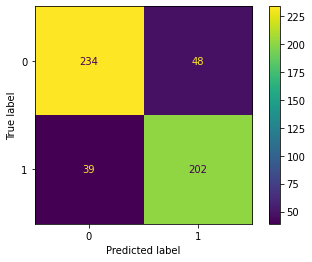

In [ ]:
import matplotlib.pyplot as plt
cm = confusion_matrix(df_final['pred_ensemble'], df_final['pred_xgb'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()
plt.show()

In [ ]:
df_final_comparation = df_final[['message', 'pred_ensemble', 'pred_xgb']]
df_difference = []
for index, row in df_final_comparation.iterrows():   
  if row['pred_ensemble'] != row['pred_xgb']:
    df_difference.append(row)

df_final_comparation = pd.DataFrame(df_difference, columns=df_final_comparation.columns).reset_index()

df_final_comparation.to_csv("./data/evaluation_final_comparation_d.csv", sep='|')

In [ ]:
evaluation_final = df_final[['message', 'pred_ensemble']]
evaluation_final['label'] = evaluation_final['pred_ensemble'].map({1: 'racist', 0: 'non-racist'}) 
evaluation_final.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,message,pred_ensemble,label
0,"""En ese momento tenías la sensación de que alg...",0,non-racist
1,"""Iraquíes no árabes ni musulmanes, los yazidíe...",0,non-racist
2,"""Perdimos el hambre de conocer y preferimos re...",0,non-racist
3,"""no he visto a los musulmanes ir contra los ho...",0,non-racist
4,"""oye tu para ser de Ecuador eres guapa EH"" ""tu...",0,non-racist


In [ ]:
df_original = pd.read_csv("./data/evaluation_final_original.csv", sep='|')

In [ ]:
for index, row in evaluation_final.iterrows():
  for index_2, row2 in  df_original:
    if row['message'] == row2['message']:
      row2['label'] = r

In [ ]:
evaluation_final = evaluation_final[['message', 'label']]
evaluation_final.to_csv("./data/evaluation_final.csv", sep='|', index=False)

In [ ]:
evaluation_final['correct_index'] = evaluation_final.label
for i in range(len(df_original)):
  for j in range(len(evaluation_final)):
    if df_original.message.iloc[i] in evaluation_final.message.iloc[j]:
      evaluation_final['correct_index'].iloc[j] = i
evaluation_final = evaluation_final.sort_values(by ='correct_index').reset_index(drop=True)
evaluation_final.head(5)

,message,label,correct_index
0,Amorcito para los bloques negros 🖤 Fuego a la ...,non-racist,0
1,@smallchicle Bueno los moros sois como los fra...,racist,1
2,Detenidos seis menores magrebíes por encerrar ...,racist,2
3,Lo de los inmigrantes ilegales es una vergüenz...,racist,3
4,"Ecoembes, entidad sin ánimo de lucro, acusada ...",non-racist,4


In [ ]:
evaluation_final = evaluation_final[['message', 'label']]
evaluation_final.to_csv("./data/evaluation_final.csv", sep='|', index=False)